NOTE: Make sure to run the script pickle_full_wildfire_data.py to pickle the full 64 x 64 data. The pickled numpy arrays will be used by the Dataset objects to load in the actual data.

In [1]:
import random
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader
import pickle
import numpy as np
import torchvision
from typing import Tuple
import matplotlib.pyplot as plt

# The PyTorch Datasets

In [2]:
def unpickle(f):
    with open(f, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def new_random_crop(labels, new_crop_size):
    crop_map = create_crop_map(len(labels), new_crop_size)
    good_indices = find_good_samples(labels, crop_map, new_crop_size)
    return crop_map, good_indices


def create_crop_map(data_size, crop_size):
    # The crop map assigns an x_shift and y_shift to each sample in the main 64 x 64 dataset.
    crop_map = []
    for i in range(data_size):
        # random.randint returns beginning <= n <= end, hence the minus 1.
        x_shift = random.randint(0, 64 - crop_size - 1)
        y_shift = random.randint(0, 64 - crop_size - 1)
        crop_map.append((x_shift, y_shift))
    return np.array(crop_map)


def get_cropped_sample(index, crop_map, crop_size, data, labels):
    x_shift, y_shift = crop_map[index]
    cropped_features = data[index, :, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
    cropped_label = labels[index, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
        
    return cropped_features, cropped_label


def find_good_samples(labels, crop_map, crop_size):
    # Finds the indices of samples that have no missing data in their labels.
    # This is determined AFTER generating a crop map and applying the crop to the original 64 x 64 label.
    good_indices = []
    for i in range(len(labels)):
        x_shift, y_shift = crop_map[i]
        if np.all(np.invert(labels[i, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size] == -1)):
            good_indices.append(i)
    return np.array(good_indices)


class WildfireDataset(torch.utils.data.Dataset):
    def __init__(self, data_filename, labels_filename):
        self.data, self.labels = unpickle(data_filename), unpickle(labels_filename)
        self.crop_size = 32
        random.seed(1)
        self.crop_map, self.good_indices = new_random_crop(self.labels, self.crop_size)
        
        print(f"data size: {self.data.nbytes}")
        print(f"label size: {self.labels.nbytes}")
        print(f"crop_map size: {self.crop_map.nbytes}")
        print(f"good_indices size: {self.good_indices.nbytes}")
        print(f"total size: {self.data.nbytes + self.labels.nbytes + self.crop_map.nbytes + self.good_indices.nbytes}")
        print("finished initializing")
        
    def __len__(self):
        return len(self.good_indices)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        index = self.good_indices[index]
        
        cropped_features, cropped_label = get_cropped_sample(index, self.crop_map, self.crop_size, self.data, self.labels)
        
        # Only keep elevation and previous fire mask
        cropped_features = cropped_features[[0, 11], :, :]

        sample = (torch.from_numpy(cropped_features), torch.from_numpy(np.expand_dims(cropped_label, axis=0)))

        return sample

In [3]:
TEST_DATA_FILENAME = '../data/next-day-wildfire-spread/test.data'
TEST_LABELS_FILENAME = '../data/next-day-wildfire-spread/test.labels'

test_dataset = WildfireDataset(TEST_DATA_FILENAME, TEST_LABELS_FILENAME)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

print(len(test_loader))
print(len(test_dataset))

data size: 332070912
label size: 27672576
crop_map size: 27024
good_indices size: 11024
total size: 359781536
finished initializing
14
1378


# The Neural Networks

In [4]:
# Code from: https://github.com/milesial/Pytorch-UNet


""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


 

""" Full assembly of the parts to form the complete network """


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# UNet Experiment 2 Discussion and Results

* Features used: Elevation and previous fire mask
* Model: UNet(2, 1, True)
* Batch size: 100
* Epochs: 100
* optimizer: torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)
* criterion: nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([75])).cuda(gpu)
* Dataset: normal WildfireDataset

Same as experiment 1, but with a weight for the fire class in the pos_weight parameter for BCEWithLogitsLoss and using the normal WildfireDataset with no augmentation for the training. Accuracy started off low which indicated that it was predicting a lot of fire. The validation accuracy began to increase but so did the validation loss, which means that it was likely overfitting and sacrificing precision on the fire class for better classification of 'no fire' pixels. 

The same BCEWithLogitsLoss function with a weight of 75 for the fire class was used to calculate the loss for the validation. This might be a mistake, and instead we should just regular BCE for the validation. Using a weight like this with BCE is not ideal since you need to fine tune it manually. Perhaps other loss functions, like dice loss, could do well here. 

I also thought that it might be better to save models based on precision and recall scores for the fire class instead of loss, since that is what we are really after.

Another thing I've noticed about the UNet model is it eventually gets a good fit for the training dataset, but it quickly struggles to generalize well to the validation dataset. This could be an indication that the datasets aren't sufficient enough to properly train and evaluate the models, or maybe the first experiment and this experiment aren't using enough features.

The BCE with the weight of 75 dramatically increased the recall, but ruined the precision by guessing fire so much more often to counteract the weighted loss for fire pixels, perhaps 75 is too high of a weight to use. 75 was calculated by finding the ratio of fire pixels to no fire pixels in the main 64 x 64 dataset, which turned out to be approximately 79 no fire pixels for every fire pixel. Maybe training the model for longer until it can achieve a higher accuracy could work, but it seems like it had a hard time breaking 90% even after 100 epochs. So it's balancing act between finding a reasonable number of epochs and a good BCE weight for the fire class.


# Loading in the model

In [5]:
MODEL_PATH = "../savedModels/unet-experiment-2/model-UNet-bestLoss-Rank-0.weights"
model = UNet(2, 1, True)

#https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/2
# original saved file with DataParallel
state_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [6]:
train_loss_history = unpickle("../savedModels/unet-experiment-2/model-UNet-train-loss-Rank-0.history")
validation_loss_history = unpickle("../savedModels/unet-experiment-2/model-UNet-validation-loss-Rank-0.history")

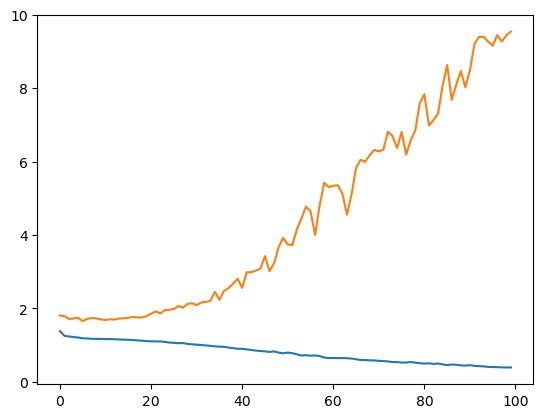

In [7]:
plt.plot(train_loss_history, linestyle="solid")
plt.plot(validation_loss_history, linestyle="solid")

In [8]:
train_loss_history = unpickle("../savedModels/unet-experiment-2/model-UNet-train-loss-Rank-1.history")
validation_loss_history = unpickle("../savedModels/unet-experiment-2/model-UNet-validation-loss-Rank-1.history")

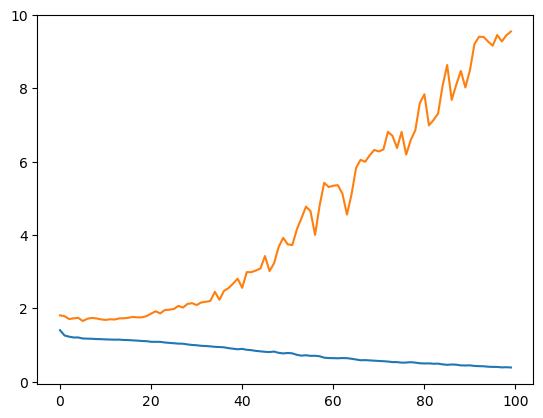

In [9]:
plt.plot(train_loss_history, linestyle="solid")
plt.plot(validation_loss_history, linestyle="solid")

# Testing the loaded in model

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def test_model(test_loader, model):   
    total = 0
    correct = 0
    incorrect = 0
    
    y_pred = []
    y_true = []
    
    model.eval()
    
    with torch.no_grad():
        
        for i, (batch_inputs, batch_labels) in enumerate(test_loader):
            out = model(batch_inputs)
            
            targets = torch.flatten(batch_labels)
            out = torch.flatten(out)
            
            fire_predictions = torch.round(torch.sigmoid(out))
            
            y_pred.extend(fire_predictions)
            y_true.extend(targets)
            
            correct += torch.sum(fire_predictions == targets)
            incorrect += torch.sum(fire_predictions != targets)
            
            total += len(targets)
    
    accuracy = 100 * correct/total
    print(f"Total = {total}")
    print(f"This should match the total: {correct + incorrect}")
    print(f"Total correct = {correct}")
    print(f"Total incorrect = {incorrect}")
    print(f"Overall accuracy: {accuracy}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\nPrecision, Recall, Fscore, Support:")
    print(np.vstack(precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])))

In [11]:
test_model(test_loader, model)

Total = 1411072
This should match the total: 1411072
Total correct = 1086083
Total incorrect = 324989
Overall accuracy: 76.9686508178711

Confusion Matrix:
[[1053029  315079]
 [   9910   33054]]

Precision, Recall, Fscore, Support:
[[9.90676793e-01 9.49464716e-02]
 [7.69697275e-01 7.69341775e-01]
 [8.66317270e-01 1.69032235e-01]
 [1.36810800e+06 4.29640000e+04]]


# Plotting the loaded in model

In [12]:
TITLES = [
    'Elevation',
    'Wind\ndirection',
    'Wind\nvelocity',
    'Min\ntemp',
    'Max\ntemp',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population\ndensity',
    'Energy\nrelease\ncomponent',
    'Previous\nfire\nmask',
    'Fire\nmask',
    'Predicted\nfire\nmask'
]

def plot_5_predictions(loader, model, offset, titles):
    with torch.no_grad():
        batch = next(iter(loader))
        out = model(batch[0])
        fire_predictions = torch.squeeze(torch.round(torch.sigmoid(out)), dim=1).numpy()
        
        print(fire_predictions.shape)
    
        n_rows = 5
        n_features = batch[0].shape[1]
    
        CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
        BOUNDS = [-1, -0.1, 0.1, 1]
        NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
        fig = plt.figure(figsize=(15,6.5))
    
    for i in range(n_rows):
        for j in range(n_features + 2):
            plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
            if i == 0:
                plt.title(titles[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(batch[0][i+offset, j, :, :], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(batch[0][i+offset, -1, :, :], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(batch[1][i+offset, 0, :, :], cmap=CMAP, norm=NORM)
            if j > n_features:
                plt.imshow(fire_predictions[i+offset], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()
    

In [13]:
test_titles = ["Elevation", "Previous\nfire\nmask", "Fire\nmask", "Predicted\nfire\mask"]

plot_5_predictions(test_loader, model, offset=35, titles=test_titles)

(100, 32, 32)


NameError: name 'colors' is not defined